**Advanced Lane Finding Project**

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### Camera Calibration

#### 1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

The code for this step is contained in the belowing code cell.  

I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `objp` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.  `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.  

I then used the output `objpoints` and `imgpoints` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function.  I applied this distortion correction to the test image using the `cv2.undistort()` function and obtained this result: 


In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        # cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        # cv2.imshow('img', img)
        # cv2.waitKey(50)

cv2.destroyAllWindows()

### Pipeline (single images)

#### 1. Provide an example of a distortion-corrected image.

To demonstrate this step, I will describe how I apply the distortion correction in the cell below.

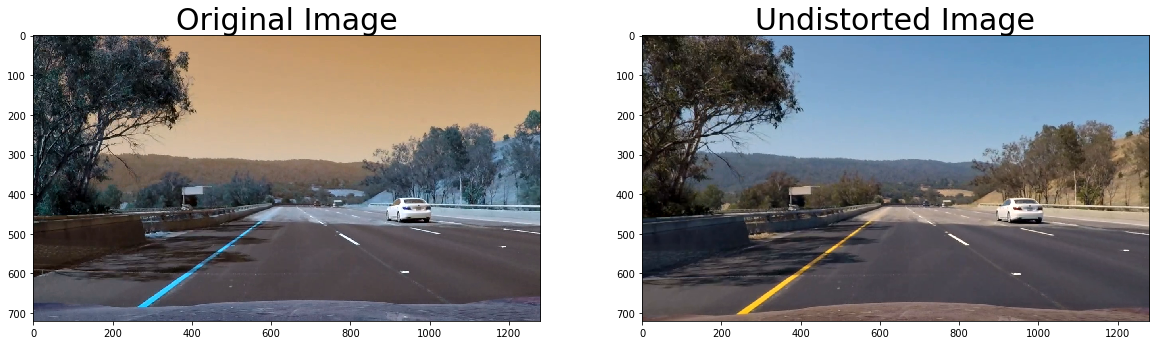

In [2]:
import pickle

# Test undistortion on an image
# img = cv2.imread('camera_cal/calibration2.jpg')
img = cv2.imread('dignose_curverad/test_10.png')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open( "wide_dist_pickle.p", "wb" ) )

dst = cv2.undistort(img, mtx, dist, None, mtx)
dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
cv2.imwrite('test_undist.jpg', dst)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

dst = None

#### 2. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image.  Provide an example of a binary image result.

I used a combination of color and gradient thresholds to generate a binary image (thresholding steps at lines # through # in `pipe.py`).  Below is how I implement this step. 

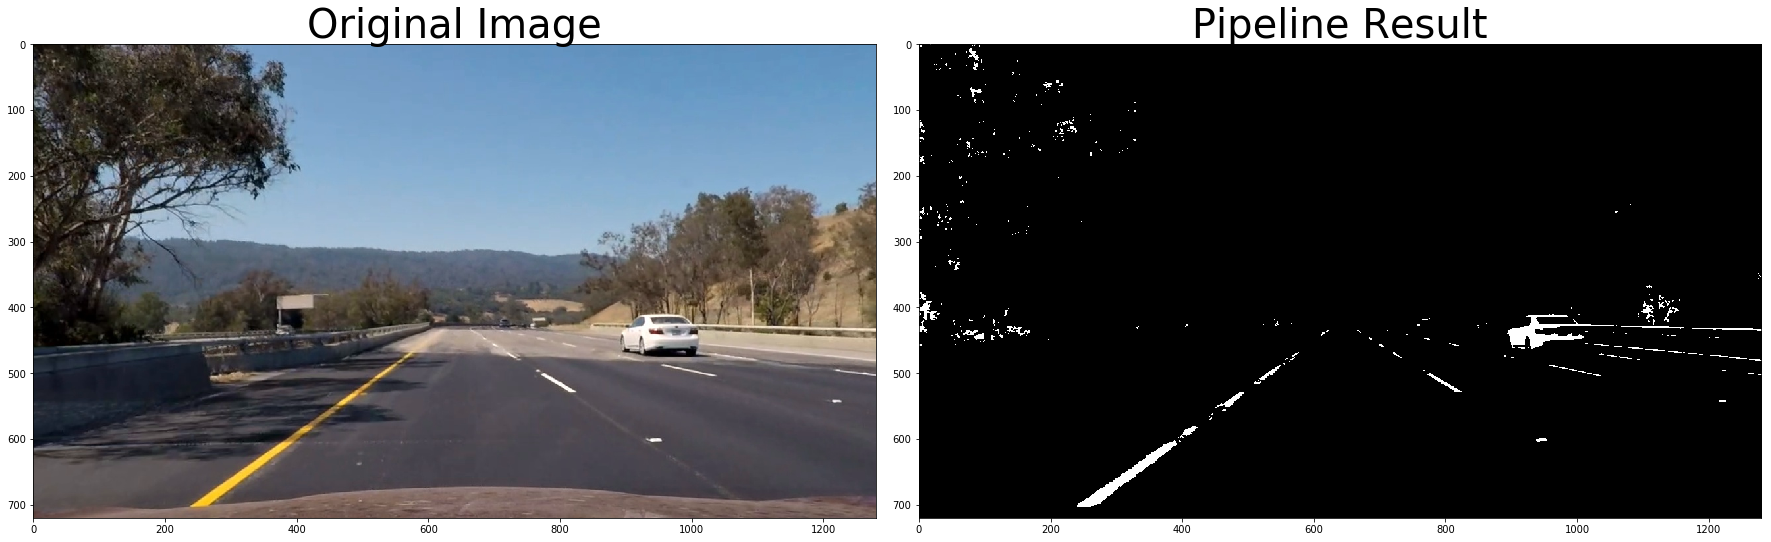

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pipe

undist = cv2.imread('test_undist.jpg')
    
color_binary, combined_binary = pipe.pipeline(undist, sx_thresh=(20, 100))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undist)
ax1.set_title('Original Image', fontsize=40)

# ax2.imshow(color_binary)
ax2.imshow(combined_binary, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

I try to clip out regions which I interest in for getting clean lane lines. But I didn't apply this step in the final process.

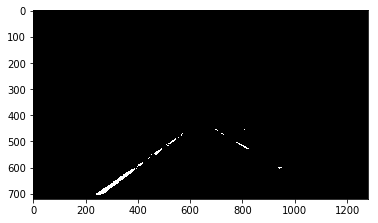

In [4]:
vertices = np.array([[(100, 720), (500, 450), (825, 450), (1200, 720)]], dtype=np.int32)

combined_binary = pipe.region_of_interest(combined_binary, vertices)
vertices = None

plt.imshow(combined_binary, cmap='gray')

#### 3. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

The code for my perspective transform includes a function called `pipe_edges2warped()`, which appears in lines 63 through 66 in the file `pipe.py`.  The `warper()` function takes as inputs an image (`image`), as well as source (`src`) and destination (`dst`) points.  I chose the hardcode the source and destination points in the manner decribed in the cell below. 

I verified that my perspective transform was working as expected by drawing the `src` and `dst` points onto a test image and its warped counterpart to verify that the lines appear parallel in the warped image.

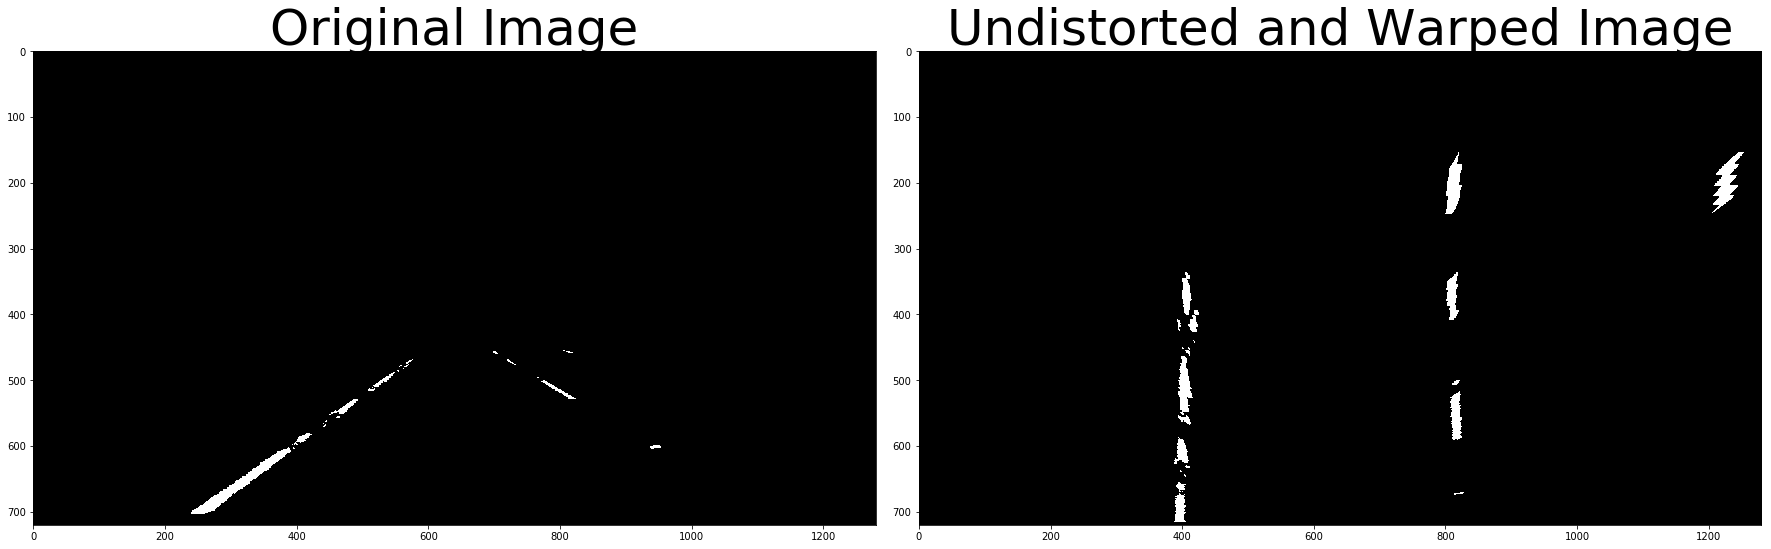

In [5]:
import pickle
# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open("wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Read in an image
# image = cv2.imread('test_undist.jpg')
image = combined_binary

src = np.float32([
    [609, 441],
    [674, 441],
    [1099, 719],
    [238, 719]
])

dst = np.float32([
    [400, -200],
    [800, -200],
    [800, 720],
    [400, 720]
])

warped = pipe.pipe_edges2warped(image, src, dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image, cmap='gray')
image = None
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped, cmap='gray')
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### 4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

Then I did some other stuff and fit my lane lines with a 2nd order polynomial kinda like this:

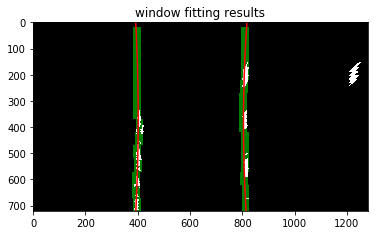

[-7.14285714e-05  5.19047619e-02  3.92511310e+02] [ 8.91842398e-05 -6.87284207e-02  8.17542847e+02]


In [6]:
# Read in a thresholded image
# warped = mpimg.imread('warped_example.jpg')
warped = warped

# window settings
window_width =  30 
window_height = 50 # Break image into 9 vertical layers since image height is 720
margin = 100       # How much to slide left and right for searching

output, ploty, left_fitx, right_fitx, left_fit, right_fit = pipe.pipe_warped2data(warped, window_width, window_height, margin)

plt.plot(left_fitx, ploty, color='red')
plt.plot(right_fitx, ploty, color='red')
plt.xlim(0, 1280)
plt.ylim(720, 0)    
    
# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()

print(left_fit, right_fit)

#### 5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

I did this in function `compute_curverad` from lines 288 to 308 in my code in `pipe.py`

In [7]:
left_curverad, right_curverad, offset = pipe.compute_curverad_offset(left_fitx, right_fitx, ploty)

print(left_curverad, right_curverad, offset)

2299.323698583753 1841.6421235603934 0.015857142857142858


#### 6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

I implemented this step in lines 202 to 222 in my code in `pipe.py` in the function `pipe_warped2origin()`. 

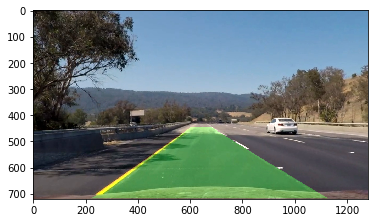

In [8]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
src = np.float32([
    [609, 441],
    [674, 441],
    [1099, 719],
    [238, 719]
])

dst = np.float32([
    [400, -200],
    [800, -200],
    [800, 720],
    [400, 720]
])
Minv = cv2.getPerspectiveTransform(dst, src)

newwarp = cv2.warpPerspective(color_warp, Minv, (warped.shape[1], warped.shape[0])) 

# Combine the result with the original image
undist = cv2.imread('test_undist.jpg')
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(result)

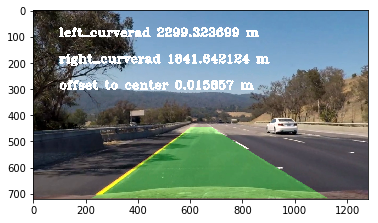

In [9]:
result = pipe.draw_curverad_offset(result, left_curverad, right_curverad, offset)

plt.imshow(result)

### Pipeline (video)

The whole pipeline code to generate output video is in pipeline.ipynb.

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).

Here's a [link to my video result](project_video_output.mp4)